# Install Pytorch Geometric

In [ ]:
import torch
#from IPython.display import clear_output
#torch_version = torch.__version__
#print("Torch version: ", torch_version)
#pytorch_version = f"torch-{torch.__version__}.html"
#!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
#!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
#!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
#!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
#!pip install torch-geometric
#clear_output()
#print("Done.")

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available. Running on GPU.")
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available. Running on GPU.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import h5py
import numpy as np
import os
import pandas as pd
import torch
from torch_geometric.data import Dataset, Data

In [ ]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

In [ ]:
import multiprocessing
print("Number of CPU cores:", multiprocessing.cpu_count())

Number of CPU cores: 72


# Load all dataset

In [ ]:
import pickle

In [ ]:
load_path = 'dataset/all_graph_data.pkl'
with open(load_path, 'rb') as f:
    all_graph_data = pickle.load(f)

In [ ]:
len(all_graph_data)

110960

In [ ]:
all_graph_data[0].y

tensor([4., 3., 2., 3., 4., 3.])

In [ ]:
def convert_y_to_integer(data):
    data.y = data.y.to(torch.int)
    return data


processed_graph_data = [convert_y_to_integer(data) for data in all_graph_data]


for i, data in enumerate(processed_graph_data[:1]):
    print(f"Graph {i}:")
    print("Node features:", data.x)
    print("Edge features:", data.edge_attr)
    print("Label:", data.y)
    print("Graph ID:", data.graph_id)
    print("-" * 50)

Graph 0:
Node features: tensor([[1.0000e+00, 9.6000e+01, 1.5400e+02, 1.3625e-03, 5.8000e+01, 5.7550e+01,
         3.0539e+00, 9.3261e+00, 2.4444e+00, 6.3846e-01, 8.2576e-01, 4.0909e-01,
         9.6176e-01, 9.0083e-01, 8.5651e-01],
        [1.0000e+00, 3.4500e+02, 1.5100e+02, 1.5667e-03, 8.8000e+01, 8.8949e+01,
         1.6839e+00, 2.8354e+00, 2.2000e+00, 6.9885e-01, 8.5455e-01, 4.5455e-01,
         9.8688e-01, 6.2548e-01, 9.2080e-01],
        [1.0000e+00, 1.4400e+02, 1.4500e+02, 1.2708e-03, 3.8000e+01, 3.8220e+01,
         1.2850e+00, 1.6512e+00, 1.1667e+00, 9.0402e-01, 8.0688e-01, 1.1667e+00,
         9.8071e-01, 4.1546e-01, 9.0445e-01],
        [1.0000e+00, 3.8400e+02, 1.4800e+02, 7.1708e-03, 8.4000e+01, 8.6330e+01,
         4.3756e+00, 1.9146e+01, 1.0323e+00, 7.8706e-01, 8.6744e-01, 1.0323e+00,
         9.6794e-01, 7.2841e-01, 8.6044e-01],
        [1.0000e+00, 3.9700e+02, 1.0300e+02, 4.5833e-04, 1.0900e+02, 1.0843e+02,
         2.3162e+00, 5.3646e+00, 4.2500e+00, 4.3948e-01, 8.0882

# Cut data based on the perception score distribution

In [ ]:
import torch
from torch_geometric.data import Data
import pickle


y_index_to_keep = 4


filtered_graph_data = []

for data in processed_graph_data:
    new_y = data.y[y_index_to_keep].unsqueeze(0)
    new_data = Data(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        y=new_y,
        graph_id=data.graph_id
    )
    filtered_graph_data.append(new_data)


print(f"Original number of graphs: {len(processed_graph_data)}")
print(f"Filtered number of graphs: {len(filtered_graph_data)}")
print(f"Sample original y: {all_graph_data[0].y}")
print(f"Sample filtered y: {filtered_graph_data[0].y}")

Original number of graphs: 110960
Filtered number of graphs: 110960
Sample original y: tensor([4, 3, 2, 3, 4, 3], dtype=torch.int32)
Sample filtered y: tensor([4], dtype=torch.int32)


In [ ]:
filtered_graph_data[0].y

tensor([4], dtype=torch.int32)

In [ ]:
output_path = 'dataset/safe_graph_data.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(filtered_graph_data, f)

print(f"Filtered graph data saved to {output_path}")

Filtered graph data saved to dataset/safe_graph_data.pkl


# Loading single-dimensional data

In [ ]:
load_path = 'safe_graph_data.pkl'
with open(load_path, 'rb') as f:
    new_graph_data = pickle.load(f)

In [ ]:
for data in new_graph_data:
    data.y = data.y - 1

# Check data distribution

In [ ]:
from collections import Counter

all_labels = [data.y.item() for data in new_graph_data]

label_counts = Counter(all_labels)

for label, count in label_counts.items():
    print(f'Class {label}: {count} samples')

Class 3: 27370 samples
Class 1: 18360 samples
Class 2: 63011 samples
Class 0: 831 samples
Class 4: 1388 samples


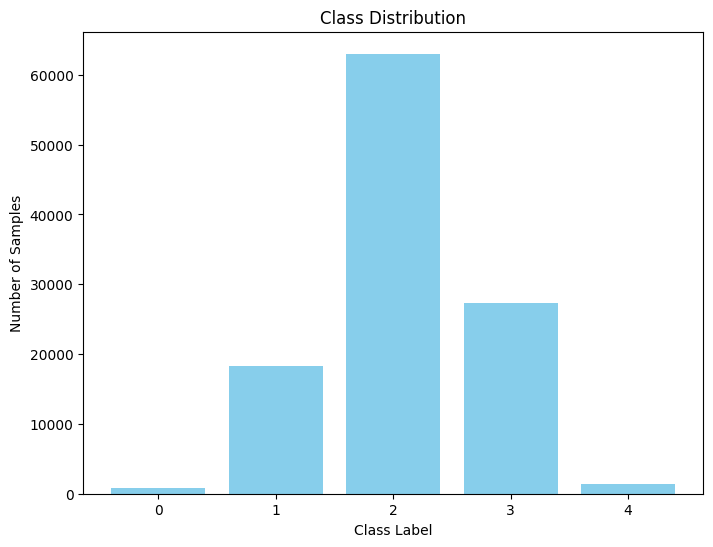

In [ ]:
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(labels)
plt.show()

# Redistribute data

In [ ]:
def augment_data(data, num_augmentations):
    augmented_data = []
    for _ in range(num_augmentations):
        new_data = data.clone()
        new_data.x += torch.randn_like(new_data.x) * 0.01
        new_data.edge_attr += torch.randn_like(new_data.edge_attr) * 0.01
        augmented_data.append(new_data)
    return augmented_data

def balance_data(data_list, target_count):
    if len(data_list) > target_count:
        return random.sample(data_list, target_count)
    else:

        while len(data_list) < target_count:
            samples_to_add = min(target_count - len(data_list), len(data_list))
            data_list.extend(random.sample(data_list, samples_to_add))
        additional_data_needed = target_count - len(data_list)
        data_list.extend(augment_data(random.choice(data_list), additional_data_needed))
        return data_list

segmented_data = {i: [] for i in range(0, 5)}
for data in new_graph_data:
    y_value = int(data.y.item())
    if y_value in segmented_data:
        segmented_data[y_value].append(data)

target_counts = {
    0: 15000,
    1: 30000,
    2: 35000,
    3: 30000,
    4: 15000
}

processed_data = []
for y_value, data_list in segmented_data.items():
    target_count = target_counts.get(y_value, 20000)
    balanced_list = balance_data(data_list, target_count)
    processed_data.extend(balanced_list)

for y_value in range(0, 5):
    count = len([data for data in processed_data if int(data.y.item()) == y_value])
    print(f'Y value {y_value}: {count} samples')

Y value 0: 15000 samples
Y value 1: 30000 samples
Y value 2: 35000 samples
Y value 3: 30000 samples
Y value 4: 15000 samples


In [ ]:
import random
import numpy as np
import torch
from torch_geometric.data import Data

def augment_data(data, num_augmentations):
    augmented_data = []
    for _ in range(num_augmentations):
        new_data = data.clone()
        new_data.x += torch.randn_like(new_data.x) * 0.01
        new_data.edge_attr += torch.randn_like(new_data.edge_attr) * 0.01
        augmented_data.append(new_data)
    return augmented_data

def balance_data(data_list, target_count=20000):
    if len(data_list) > target_count:
        return random.sample(data_list, target_count)
    else:

        while len(data_list) < target_count:
            samples_to_add = min(target_count - len(data_list), len(data_list))
            data_list.extend(random.sample(data_list, samples_to_add))
            if len(data_list) >= target_count:
                break
        additional_data_needed = target_count - len(data_list)
        data_list.extend(augment_data(random.choice(data_list), additional_data_needed))
        return data_list

segmented_data = {i: [] for i in range(0, 5)}
for data in new_graph_data:
    y_value = int(data.y.item())
    if y_value in segmented_data:
        segmented_data[y_value].append(data)

processed_data = []
for y_value, data_list in segmented_data.items():
    balanced_list = balance_data(data_list, target_count=20000)
    processed_data.extend(balanced_list)

for y_value in range(0, 5):
    count = len([data for data in processed_data if int(data.y.item()) == y_value])
    print(f'Y value {y_value}: {count} samples')

for i, data in enumerate(processed_data[:1]):
    print(f"Graph {i}:")
    print("Node features:", data.x)
    print("Edge features:", data.edge_attr)
    print("Label:", data.y)
    print("Graph ID:", data.graph_id)
    print("-" * 50)

Y value 0: 20000 samples
Y value 1: 20000 samples
Y value 2: 20000 samples
Y value 3: 20000 samples
Y value 4: 20000 samples
Graph 0:
Node features: tensor([[2.0000e+00, 2.5000e+02, 6.1000e+01, 1.7311e-01, 5.3000e+01, 5.9661e+01,
         2.4259e+01, 5.8849e+02, 2.5765e+00, 4.2521e-01, 5.9913e-01, 2.5765e+00,
         8.5862e-01, 9.1739e-01, 9.5739e-01],
        [4.0000e+00, 3.1800e+02, 1.3200e+02, 7.4504e-02, 8.2000e+01, 8.1442e+01,
         1.3402e+01, 1.7961e+02, 2.4198e+00, 4.1208e-01, 5.4988e-01, 4.1326e-01,
         7.6326e-01, 9.5556e-01, 9.3006e-01],
        [4.0000e+00, 3.2600e+02, 2.0000e+01, 5.2021e-02, 1.1800e+02, 1.1506e+02,
         1.2031e+01, 1.4475e+02, 2.9385e+00, 2.8147e-01, 5.0282e-01, 3.4031e-01,
         6.9616e-01, 9.7821e-01, 8.7217e-01],
        [4.0000e+00, 1.2200e+02, 5.9000e+01, 5.3883e-02, 9.0000e+01, 9.0305e+01,
         1.1986e+01, 1.4366e+02, 2.6576e+00, 4.8258e-01, 6.5538e-01, 2.6576e+00,
         8.6821e-01, 9.3250e-01, 8.8641e-01],
        [6.0000e+00

In [ ]:
output_path = 'processed_data.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(processed_data, f)

print(f"processed_data saved to {output_path}")

processed_data saved to processed_data.pkl


# Data Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
all_node_features = []
all_edge_features = []

for data in processed_data:
    all_node_features.append(data.x.numpy())
    all_edge_features.append(data.edge_attr.numpy())

all_node_features = np.vstack(all_node_features)
all_edge_features = np.vstack(all_edge_features)

x_scaler = MinMaxScaler()
edge_scaler = MinMaxScaler()

x_scaler.fit(all_node_features)
edge_scaler.fit(all_edge_features)

x_scaler_path = 'x_scaler.pkl'
edge_scaler_path = 'edge_scaler.pkl'

with open(x_scaler_path, 'wb') as f:
    pickle.dump(x_scaler, f)
print(f"x_scaler saved at {x_scaler_path}")

with open(edge_scaler_path, 'wb') as f:
    pickle.dump(edge_scaler, f)
print(f"edge_scaler saved at {edge_scaler_path}")

normalized_graph_data = []
for data in processed_data:
    normalized_x = torch.tensor(x_scaler.transform(data.x.numpy()), dtype=torch.float)
    normalized_edge_attr = torch.tensor(edge_scaler.transform(data.edge_attr.numpy()), dtype=torch.float)
    normalized_data = Data(x=normalized_x, edge_index=data.edge_index, edge_attr=normalized_edge_attr, y=data.y, graph_id=data.graph_id)
    normalized_graph_data.append(normalized_data)

x_scaler saved at x_scaler.pkl
edge_scaler saved at edge_scaler.pkl


In [ ]:
len(normalized_graph_data)

125000

In [ ]:
output_path = 'normalized_graph_data.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(normalized_graph_data, f)

print(f"normalized_graph_data saved to {output_path}")

normalized_graph_data saved to normalized_graph_data.pkl


# K-fold

In [ ]:
from torch.utils.data import Dataset, Subset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [ ]:
class MyGraphDataset(Dataset):
    def __init__(self, normalized_graph_data):
        self.normalized_graph_data = normalized_graph_data

    def __len__(self):
        return len(self.normalized_graph_data)

    def __getitem__(self, idx):
        return self.normalized_graph_data[idx]

dataset = MyGraphDataset(normalized_graph_data)

# **Create Model GIN**

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch.nn import Linear, Sequential, ReLU

class GNN(torch.nn.Module):
    def __init__(self, num_features, embedding_size=64, dropout_rate=0.3, num_classes=5):
        super(GNN, self).__init__()
        nn1 = Sequential(Linear(num_features, embedding_size), ReLU(), Linear(embedding_size, embedding_size))
        self.initial_conv = GINConv(nn1)
        nn2 = Sequential(Linear(embedding_size, embedding_size), ReLU(), Linear(embedding_size, embedding_size))
        self.conv1 = GINConv(nn2)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.out = Linear(embedding_size, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.initial_conv(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.out(x)
        return x

# GraphSAGE Model

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch.nn import Linear

class GNN(torch.nn.Module):
    def __init__(self, num_features, embedding_size=64, dropout_rate=0.3, num_classes=5):
        super(GNN, self).__init__()
        self.initial_conv = SAGEConv(num_features, embedding_size)
        self.conv1 = SAGEConv(embedding_size, embedding_size)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.out = Linear(embedding_size, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.initial_conv(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.out(x)
        return x

# GCN Model

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear

class GNN(torch.nn.Module):
    def __init__(self, num_features, embedding_size=64, dropout_rate=0.3, num_classes=5):
        super(GNN, self).__init__()
        self.initial_conv = GCNConv(num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.out = Linear(embedding_size, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.initial_conv(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.out(x)
        return x

# GAT Model

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch.nn import Linear

class GNN(torch.nn.Module):
    def __init__(self, num_features, embedding_size=64, dropout_rate=0.3, num_classes=5, heads=4):
        super(GNN, self).__init__()
        self.initial_conv = GATConv(num_features, embedding_size // heads, heads=heads)
        self.conv1 = GATConv(embedding_size, embedding_size // heads, heads=heads)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.out = Linear(embedding_size, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.initial_conv(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.out(x)
        return x

# Training functions and hyperparameters

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

fold_results = []

In [ ]:
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

def initialize_model():
    num_features = 15
    embedding_size = 64
    num_classes = 5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNN(num_features=num_features, embedding_size=embedding_size, dropout_rate=0.3, num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)  # GAT
    scaler = GradScaler()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    return model, optimizer, scaler, scheduler, device

def train(loader, model, optimizer, scaler, device):
    model.train()
    total_loss = 0
    for batch_idx, data in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()
        with autocast():
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y.long().view(-1))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def test(loader, model, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            data = data.to(device)
            with autocast():
                out = model(data.x, data.edge_index, data.batch)
                loss = F.cross_entropy(out, data.y.long().view(-1))
            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += pred.eq(data.y.long().view(-1)).sum().item()
    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader.dataset), accuracy

# Training

In [ ]:
from torch_geometric.loader import DataLoader
import os
import matplotlib.pyplot as plt

checkpoint_dir = '1_13GIN/'
os.makedirs(checkpoint_dir, exist_ok=True)

fold_results = []

train_losses_all_folds = []
val_losses_all_folds = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold + 1}')
    print('--------------------------------')

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model, optimizer, scaler, scheduler, device = initialize_model()

    num_epochs = 700
    best_val_accuracy = float('-inf')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        train_loss = train(train_loader, model, optimizer, scaler, device)
        print(f'Train Loss: {train_loss:.4f}')
        train_losses.append(train_loss)

        val_loss, val_accuracy = test(val_loader, model, device)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            print(f'New Best Validation Accuracy for fold {fold + 1}: {best_val_accuracy:.4f}')
            best_checkpoint_path = os.path.join(checkpoint_dir, f'best_model_fold_{fold + 1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, best_checkpoint_path)
            print(f'Best model checkpoint saved for fold {fold + 1} at epoch {epoch + 1}.')

        if (epoch + 1) % 50 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'model_fold_{fold + 1}_epoch_{epoch + 1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, checkpoint_path)
            print(f'Checkpoint saved for fold {fold + 1} at epoch {epoch + 1}.')

    train_losses_all_folds.append(train_losses)
    val_losses_all_folds.append(val_losses)

    fold_results.append(best_val_accuracy)
    print(f'Best Validation Accuracy for fold {fold + 1}: {best_val_accuracy:.4f}')

FOLD 1
--------------------------------


/home/evl/zke4/anaconda3/envs/mask_envir2/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/700
Train Loss: 1.5249
Validation Loss: 1.5054, Validation Accuracy: 0.3077
New Best Validation Accuracy for fold 1: 0.3077
Best model checkpoint saved for fold 1 at epoch 1.
Epoch 2/700
Train Loss: 1.4836
Validation Loss: 1.4664, Validation Accuracy: 0.3250
New Best Validation Accuracy for fold 1: 0.3250
Best model checkpoint saved for fold 1 at epoch 2.
Epoch 3/700
Train Loss: 1.4619
Validation Loss: 1.4574, Validation Accuracy: 0.3300
New Best Validation Accuracy for fold 1: 0.3300
Best model checkpoint saved for fold 1 at epoch 3.
Epoch 4/700
Train Loss: 1.4513
Validation Loss: 1.4440, Validation Accuracy: 0.3395
New Best Validation Accuracy for fold 1: 0.3395
Best model checkpoint saved for fold 1 at epoch 4.
Epoch 5/700
Train Loss: 1.4447
Validation Loss: 1.4413, Validation Accuracy: 0.3395
Epoch 6/700
Train Loss: 1.4396
Validation Loss: 1.4339, Validation Accuracy: 0.3436
New Best Validation Accuracy for fold 1: 0.3436
Best model checkpoint saved for fold 1 at epoch 6.
E

# Check loss

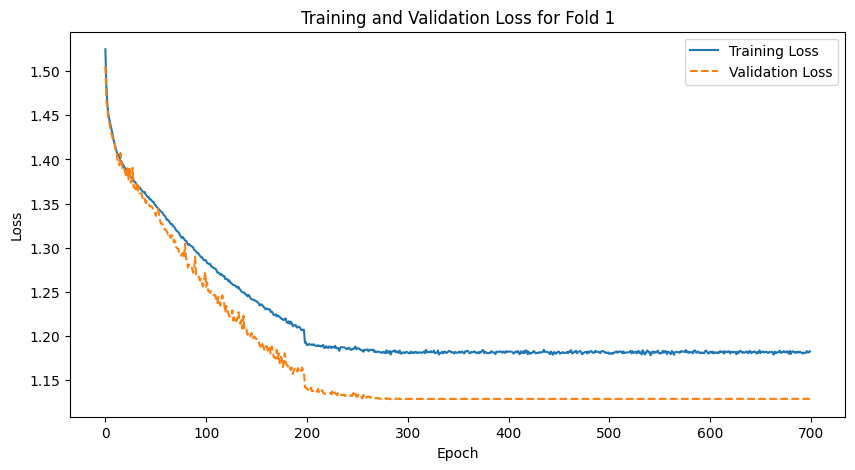

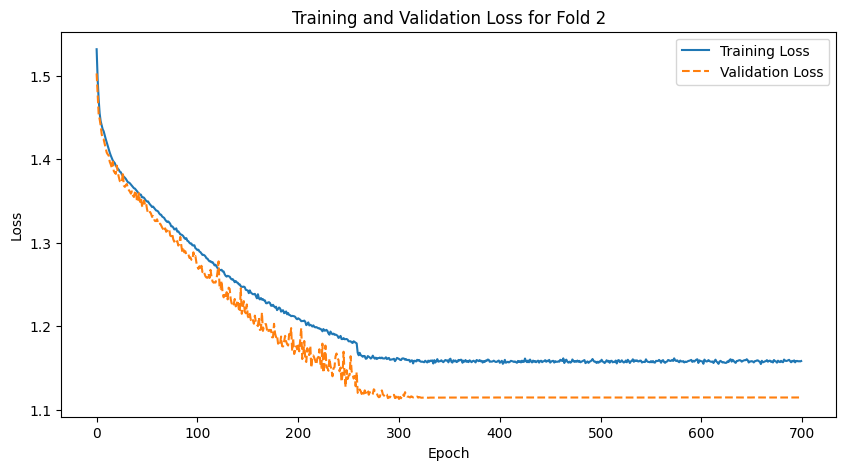

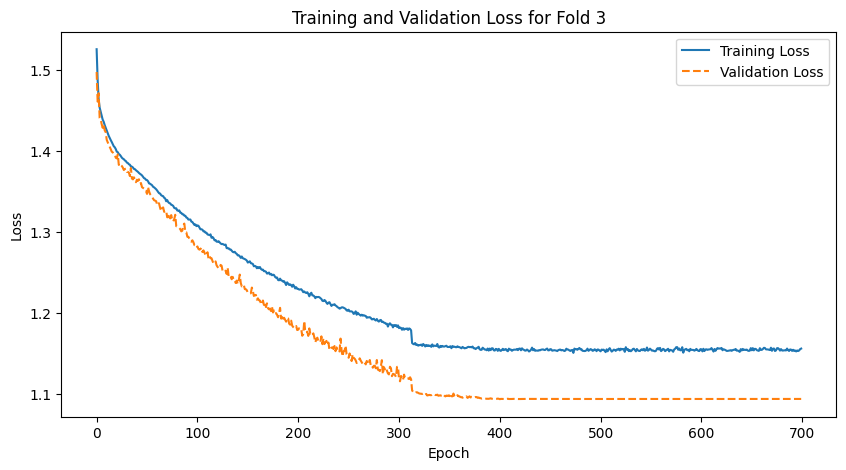

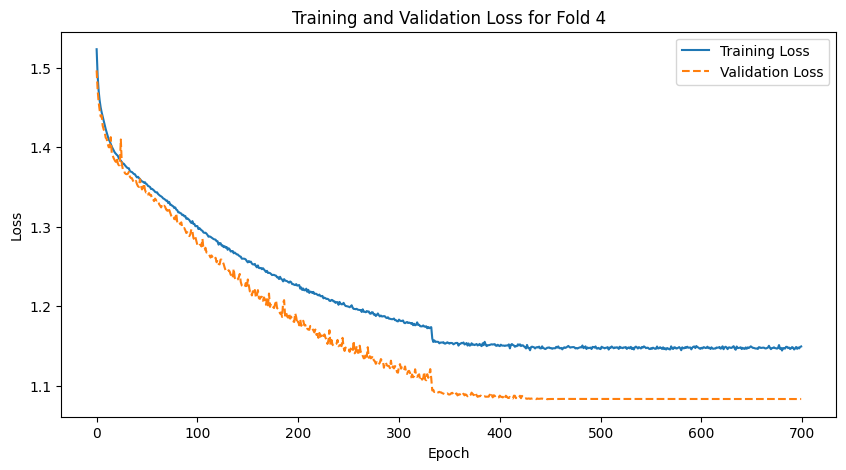

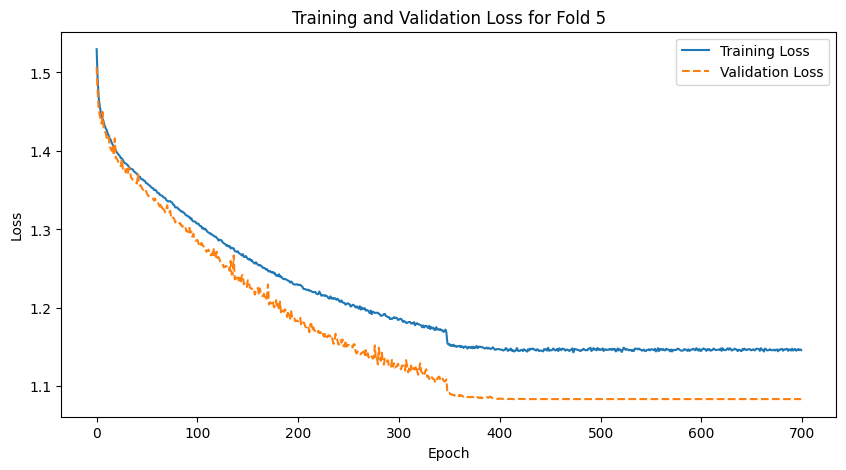

In [ ]:
for fold in range(len(train_losses_all_folds)):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_all_folds[fold], label='Training Loss')
    plt.plot(val_losses_all_folds[fold], label='Validation Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for Fold {fold + 1}')
    plt.legend()
    plt.show()

# Save best fold

In [ ]:
best_fold_idx = fold_results.index(max(fold_results))
print(f'Best fold: {best_fold_idx + 1}, Best Validation Accuracy: {max(fold_results):.4f}')

best_checkpoint_path = os.path.join(checkpoint_dir, f'best_model_fold_{best_fold_idx + 1}.pth')
checkpoint = torch.load(best_checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])

complete_model_save_path = '1_13GIN/complete_model_1.13.pth'
torch.save(model, complete_model_save_path)
print(f'Best model from fold {best_fold_idx + 1} saved to {complete_model_save_path}')

Best fold: 5, Best Validation Accuracy: 0.4900
Best model from fold 5 saved to 1_13GIN/complete_model_1.13.pth


In [ ]:
best_fold = best_fold_idx
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    if fold == best_fold:
        np.save('1_13GIN/best_fold_train_idx.npy', train_idx)
        np.save('1_13GIN/best_fold_val_idx.npy', val_idx)
        print(f"Best fold train and val indices saved for fold {fold + 1}.")
        break

Best fold train and val indices saved for fold 5.


# Load dataset in best fold

In [ ]:
train_idx = np.load('1_13GIN/best_fold_train_idx.npy')
val_idx = np.load('1_13GIN/best_fold_val_idx.npy')

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [ ]:
len(train_subset)

100000

In [ ]:
first_data = train_subset[0]
print(first_data)

Data(x=[12, 15], edge_index=[2, 21], edge_attr=[21, 1], y=[1], graph_id='513d6906fdc9f035870045a2')


# Evaluating the Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
preds = []
gt = []

with torch.no_grad():
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        preds.extend(out.argmax(dim=1).cpu().detach().numpy())
        gt.extend(data.y.cpu().detach().numpy())

df = pd.DataFrame()
df["preds"] = preds
df["gt"] = gt

print("Validation Accuracy: ", accuracy_score(df["gt"], df["preds"]))
print("Validation Precision: ", precision_score(df["gt"], df["preds"], average='weighted'))
print("Validation Recall: ", recall_score(df["gt"], df["preds"], average='weighted'))
print("Validation F1 Score: ", f1_score(df["gt"], df["preds"], average='weighted'))

print(df.head(10))

Validation Accuracy:  0.50116
Validation Precision:  0.49250278161217415
Validation Recall:  0.50116
Validation F1 Score:  0.49591966171085
   preds  gt
0      0   0
1      0   0
2      0   0
3      0   0
4      0   0
5      0   0
6      0   0
7      0   0
8      0   0
9      0   0


In [ ]:
df.to_csv('1_13GIN/predictions.csv', index=False)

Confusion Matrix

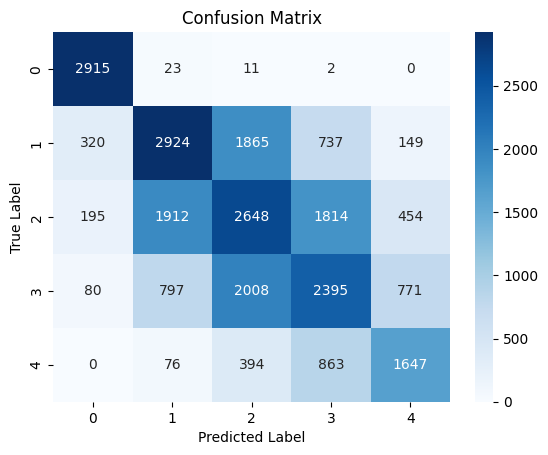

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = [0, 1, 2, 3, 4]

cm = confusion_matrix(df["gt"], df["preds"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()